## 单流体嵌入网络的PBFs聚合物

In [1]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
# 使用MinMaxScaler进行归一化
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# 读取高保真数据
url_hf = 'Data/Data_HF.xlsx'
df_HF = pd.read_excel(url_hf, sheet_name=None)
data_HF = [[k, v] for k, v in df_HF.items()]

sample = 1
data_HF[sample][1] = data_HF[sample][1].dropna()
df_hf = data_HF[sample][1]  # entire data
data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].DP != 162]

# 转换为NumPy数组
X = data_HF[sample][1][['DP', 'Mn', 'PDI', 'AngFreq']].values
y = data_HF[sample][1]['LossFactor'].values.reshape(-1, 1)

# 对频率列进行对数化
X[:, 3] = np.log10(X[:, 3])

# 归一化高保真训练数据
scaler_X_hf = MinMaxScaler()
scaler_y_hf = MinMaxScaler()

X_normalized = scaler_X_hf.fit_transform(X)
y_normalized = scaler_y_hf.fit_transform(y)

# 转换为PyTorch张量
X_data_HF = torch.tensor(X_normalized, dtype=DTYPE)
y_data_HF = torch.tensor(y_normalized, dtype=DTYPE)

# 处理高保真测试集
data_test = df_hf[df_hf.DP == 162.]
X_test = data_test[['DP', 'Mn', 'PDI', 'AngFreq']].values
y_test = data_test['LossFactor'].values.reshape(-1, 1)

# 对测试集频率进行对数化
X_test[:, 3] = np.log10(X_test[:, 3])

# 使用训练集的归一化器对测试集进行归一化
X_test_normalized = scaler_X_hf.transform(X_test)
y_test_normalized = scaler_y_hf.transform(y_test)

# 转换测试集为PyTorch张量
X_test_tensor = torch.tensor(X_test_normalized, dtype=DTYPE)
y_test_tensor = torch.tensor(y_test_normalized, dtype=DTYPE)

# 读取低保真数据
url_lf = 'Data/Data_LF_S_PFGs.xlsx'
df_LF = pd.read_excel(url_lf, sheet_name='Sheet1')
df_LF = df_LF.dropna()
df_LF = df_LF[df_LF.DP != 162]

# 转换为NumPy数组
X_lf = df_LF[['DP', 'Mn', 'PDI', 'AngFreq']].values
y_lf = df_LF['LossFactor'].values.reshape(-1, 1)

# 对频率列进行对数化
X_lf[:, 3] = np.log10(X_lf[:, 3])

# 归一化低保真数据(使用独立的归一化器)
scaler_X_lf = MinMaxScaler()
scaler_y_lf = MinMaxScaler()

X_lf_normalized = scaler_X_lf.fit_transform(X_lf)
y_lf_normalized = scaler_y_lf.fit_transform(y_lf)

# 转换为PyTorch张量
X_lf_tensor = torch.tensor(X_lf_normalized, dtype=DTYPE)
y_lf_tensor = torch.tensor(y_lf_normalized, dtype=DTYPE)

# 定义模型
in_dim, out_dim = 4, 1

In [3]:
# 神经网络的类
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

In [4]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self, model_HF_nl, model_HF_l,model_LF):
        self.model_LF = model_LF # 低保真模型
        self.model_HF_nl = model_HF_nl # 高保真非线性模型
        self.model_HF_l = model_HF_l # 高保真线性模型

        self.hist =  [[], []] # loss历史列表,0:total loss ;1:LF loss
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_HF, y_data_HF,X_lf_tensor ,y_lf_tensor):    
        y_pred_LF = self.model_LF(X_lf_tensor)

        y_pred_LF_HF = self.model_LF(X_data_HF)
   
        # 将X_data_HF和y_pred_LF_HF在特征维度上拼接
        X_combined = torch.cat([X_data_HF, y_pred_LF_HF], dim=1)

        y_pred_HF_nl = self.model_HF_nl(X_combined)
        y_pred_HF_l = self.model_HF_l(X_combined)

        y_pred_HF = y_pred_HF_nl + y_pred_HF_l

        Loss_L2 = 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_HF_nl.parameters())
        Loss_L2 += 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_HF_l.parameters())
        Loss_L2 += 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_LF.parameters())
        Loss_data_LF = torch.mean((y_lf_tensor - y_pred_LF)**2)

        Loss_data_HF = torch.mean((y_data_HF - y_pred_HF)**2)+Loss_L2
        # Total_loss=Loss_data_LF+Loss_data_HF
        Total_loss=Loss_data_HF
        return Total_loss,Loss_data_LF
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer,data,scheduler,N=1001):
        """This method performs a gradient descent type optimization."""        
        for i in range(N):
            # 梯度清0
            optimizer.zero_grad()
            # 计算loss          
            loss,loss_lf = self.loss_fn(data[0], data[1],data[2],data[3])
            # 反向传播计算梯度
            loss.backward()
            # 根据loss调度学习率
            scheduler.step(loss)
            # 反向传播更新权重和偏置
            optimizer.step()

            # 记录loss并计算相对误差
            self.current_loss = loss.item()
            self.lf_loss=loss_lf.item()
           
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error,N)  # Pass max_relative_error to the callback function
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3: # in %
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 3)))
                break

    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 500 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist[0].append(self.current_loss)
        self.hist[1].append(self.lf_loss)
        self.iter+=1
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)

        # 绘制训练集损失曲线
        ax.semilogy(range(len(self.hist[0])), self.hist[0], 'b-', label='Training Loss')
        
        # 绘制验证集损失曲线
        ax.semilogy(range(len(self.hist[1])), self.hist[1], 'g-', label='LF Loss')

        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$loss$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        ax.legend()  # 添加图例
        return ax

In [5]:
# 定义模型
model_LF = PINN_NeuralNet(input_dim=in_dim,
                         output_dim=out_dim,
                         num_hidden_layers=4,
                         num_neurons_per_layer=64,
                         activation='relu'
                         )
model_HF_nl = PINN_NeuralNet(input_dim=in_dim+out_dim,
                             output_dim=out_dim,
                             num_hidden_layers=4,
                             num_neurons_per_layer=64,
                             activation='relu')
model_HF_l = PINN_NeuralNet(input_dim=in_dim+out_dim,
                            output_dim=out_dim,
                            num_hidden_layers=1,
                            num_neurons_per_layer=10,
                            activation='linear')

# 初始化 PINNSolver
solver = PINNSolver(model_HF_nl, model_HF_l,model_LF)

In [6]:
# 定义学习率调度器
lr = 1e-3
optimizer = optim.Adam(list(model_HF_nl.parameters()) + list(model_HF_l.parameters())+list(model_LF.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True)
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(4000) + 1  # 训练迭代次数

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        t0 = time()
        solver.solve_with_PyTorch_optimizer(optimizer, [X_data_HF,y_data_HF,X_lf_tensor,y_lf_tensor],scheduler,N=N)
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

/home/redfu/anaconda3/envs/PINN/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


It 0,000: Loss = 9.4068e-02, Max. rel. error = 100 %
It 0,500: Loss = 2.9212e-03, Max. rel. error = 0.83 %
It 1,000: Loss = 2.6453e-03, Max. rel. error = 0.31 %
It 1,500: Loss = 2.4894e-03, Max. rel. error = 0.2 %
It 2,000: Loss = 2.3782e-03, Max. rel. error = 0.25 %
It 2,500: Loss = 2.2896e-03, Max. rel. error = 0.22 %
It 3,000: Loss = 2.2149e-03, Max. rel. error = 0.12 %
It 3,500: Loss = 2.1500e-03, Max. rel. error = 0.1 %
It 4,000: Loss = 2.0931e-03, Max. rel. error = 0.1 %

Runtime: 0.766 minutes


<Axes: xlabel='$n_{epoch}$', ylabel='$loss$'>

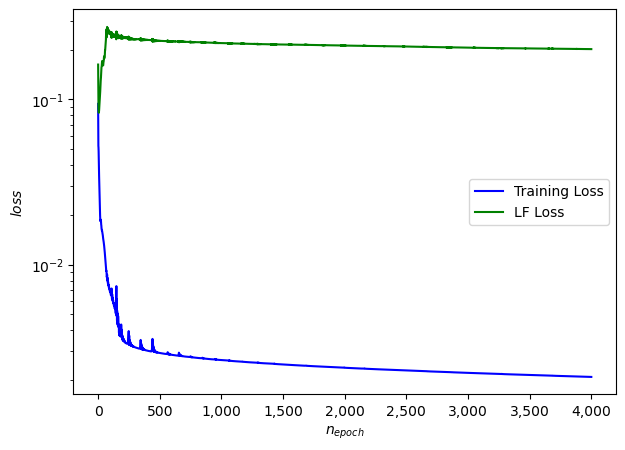

In [7]:
solver.plot_loss_history()

/tmp/ipykernel_13234/2387378547.py:36: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


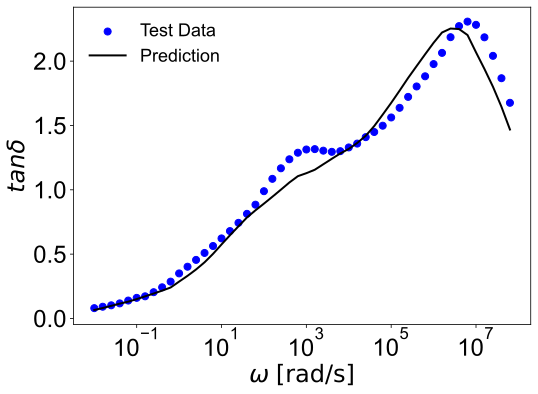

In [8]:
# 设置字体为Arial
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=24)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=24)

fig, ax = plt.subplots(figsize=(8, 6),dpi=600)

# 使用模型预测
y_lf = solver.model_LF(X_test_tensor)
X_pred_hf = torch.cat([X_test_tensor, y_lf], dim=1)
y_pred = solver.model_HF_nl(X_pred_hf) + solver.model_HF_l(X_pred_hf)
y_pred_denorm = scaler_y_hf.inverse_transform(y_pred.detach().numpy())

# 对预测数据进行排序以绘制平滑曲线
sort_idx = np.argsort(X_test[:,3])
x_sorted = X_test[sort_idx,3]
y_pred_sorted = y_pred_denorm[sort_idx]

# 绘制预测值和实验值的对比
ax.scatter(10**X_test[:,3], y_test, color='blue', marker='o', s=50, label='Test Data')
ax.plot(10**x_sorted, y_pred_sorted, color='black', linewidth=2, label='Prediction')

ax.set_xscale('log')
ax.set_ylabel('$tan\delta$')
ax.set_xlabel('$\omega$ $\mathrm{[rad/s]}$')
ax.legend(frameon=False)
plt.tight_layout()

# 设置输出为SVG格式
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.show()

In [9]:
# 导入评估指标所需的库
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 计算评估指标
# R2 - 决定系数
r2 = r2_score(y_test, y_pred_denorm)

# MAE - 平均绝对误差
mae = mean_absolute_error(y_test, y_pred_denorm)

# RMSE - 均方根误差
rmse = np.sqrt(mean_squared_error(y_test, y_pred_denorm))

# MAPE - 平均绝对百分比误差
mape = np.mean(np.abs((y_test - y_pred_denorm) / y_test)) * 100

# 打印评估指标
print("模型预测性能评估指标:")
print(f"R² (决定系数): {r2:.4f}")
print(f"MAE (平均绝对误差): {mae:.4f}")
print(f"RMSE (均方根误差): {rmse:.4f}")
print(f"MAPE (平均绝对百分比误差): {mape:.2f}%")

# 创建一个包含所有指标的表格
from tabulate import tabulate
metrics_table = [
    ["指标", "值"],
    ["R²", f"{r2:.4f}"],
    ["MAE", f"{mae:.4f}"],
    ["RMSE", f"{rmse:.4f}"],
    ["MAPE", f"{mape:.2f}%"]
]
print("\n" + tabulate(metrics_table, headers="firstrow", tablefmt="grid"))


模型预测性能评估指标:
R² (决定系数): 0.9726
MAE (平均绝对误差): 0.0894
RMSE (均方根误差): 0.1159
MAPE (平均绝对百分比误差): 8.41%

+--------+--------+
| 指标   | 值     |
+========+========+
| R²     | 0.9726 |
+--------+--------+
| MAE    | 0.0894 |
+--------+--------+
| RMSE   | 0.1159 |
+--------+--------+
| MAPE   | 8.41%  |
+--------+--------+


In [10]:
# 保存模型的状态字典
# torch.save(model_HF_nl.state_dict(), 'model/model_nl_pinn_pbfs_lossf.pth')
# torch.save(model_HF_l.state_dict(), 'model/model_l_pinn_pbfs_lossf.pth')

R²     | 0.9755 |
+--------+--------+
| MAE    | 0.0879 |
+--------+--------+
| RMSE   | 0.1096 |
+--------+--------+
| MAPE   | 14.03% 